In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enron-email-dataset/emails.csv


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import email

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
df = pd.read_csv('/kaggle/input/enron-email-dataset/emails.csv')
df.shape

(517401, 2)

In [6]:
df.head()


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [7]:
df.dtypes

file       object
message    object
dtype: object

In [8]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,df['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

# Goes through each email and grabs info for each key
# doc['From'] grabs who sent email in all emails
for key in headings:
    df[key] = [doc[key] for doc in emails]

In [9]:
##Useful functions
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [10]:
df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,user
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [11]:
df.dtypes

file                         object
message                      object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
body                         object
user                         object
dtype: object

In [12]:
data = df[['message', 'Subject', 'From', 'To', 'body', 'user']]
data.head(2)

,message,Subject,From,To,body,user
0,Message-ID: <18782981.1075855378110.JavaMail.e...,,phillip.allen@enron.com,tim.belden@enron.com,Here is our forecast\n\n,allen-p
1,Message-ID: <15464986.1075855378456.JavaMail.e...,Re:,phillip.allen@enron.com,john.lavorato@enron.com,Traveling to have a business meeting takes the...,allen-p


In [13]:
data.shape

(517401, 6)

In [14]:
data["To"].nunique()

58563

In [15]:
recipient_counts  = data["To"].value_counts()
sorted_recipients = recipient_counts.sort_values(ascending=False)

# Select the top 5 recipients
top_5_recipients = sorted_recipients.head(5)

# Display the top 5 recipients
print("Top 5 recipients:")
print(top_5_recipients)


Top 5 recipients:
pete.davis@enron.com         9155
tana.jones@enron.com         5677
sara.shackleton@enron.com    4974
vkaminski@aol.com            4870
jeff.dasovich@enron.com      4350
Name: To, dtype: int64


In [16]:
# Find the top 5 recipients
top_recipients = data['To'].value_counts().nlargest(5).index.tolist()

# Select the data for emails sent to the top 5 recipients
selected_data = data[data['To'].isin(top_recipients)]

In [17]:
selected_data["To"].value_counts()

pete.davis@enron.com         9155
tana.jones@enron.com         5677
sara.shackleton@enron.com    4974
vkaminski@aol.com            4870
jeff.dasovich@enron.com      4350
Name: To, dtype: int64

In [18]:
selected_data.head()

,message,Subject,From,To,body,user
777,Message-ID: <14286989.1075855666059.JavaMail.e...,Re: Enron Response to San Diego Request for Ga...,stephanie.miller@enron.com,jeff.dasovich@enron.com,Any merit to mentioning that there has been an...,allen-p
2086,Message-ID: <1735118.1075855679365.JavaMail.ev...,Re: Enron Response to San Diego Request for Ga...,stephanie.miller@enron.com,jeff.dasovich@enron.com,Any merit to mentioning that there has been an...,allen-p
2136,Message-ID: <27155845.1075858639875.JavaMail.e...,RE: Call to Discuss Possible Options to Mitiga...,k..allen@enron.com,jeff.dasovich@enron.com,"\njeff,\n\nIs the problem that the energy DWR ...",allen-p
8588,Message-ID: <21855864.1075863607038.JavaMail.e...,information from iso,robert.badeer@enron.com,jeff.dasovich@enron.com,"Jeff,\n Tim told me to put together a list of ...",badeer-r
8590,Message-ID: <24408121.1075863607081.JavaMail.e...,Re:,robert.badeer@enron.com,jeff.dasovich@enron.com,what is your fax number?,badeer-r


In [19]:
selected_data.shape

(29026, 6)

In [20]:
row_index = 777  # Replace with the index of the desired row
body = selected_data.loc[row_index, 'body']
print(body)


Any merit to mentioning that there has been an initial "supply" response in 
terms of pipeline infrastructure - open seasons/expansion efforts on behalf 
of Kern River, Transwestern and PGT (not yet announced)? 


From: Jeff Dasovich on 12/13/2000 12:04 PM
Sent by: Jeff Dasovich
To: Sarah Novosel/Corp/Enron@ENRON
cc: Christi L Nicolay/HOU/ECT@ECT, James D Steffes/NA/Enron@ENRON, Joe 
Hartsoe/Corp/Enron@ENRON, Mary Hain/HOU/ECT@ECT, pallen@enron.com, 
pkaufma@enron.com, Richard B Sanders/HOU/ECT@ECT, Richard 
Shapiro/NA/Enron@ENRON, Stephanie Miller/Corp/Enron@ENRON, Steven J 
Kean/NA/Enron@ENRON, Susan J Mara/NA/Enron@ENRON 

Subject: Re: Enron Response to San Diego Request for Gas Price Caps  

Recognizing the time constraints you face, I've tried to 1) clear up a few 
inaccuracies and 2) massage some of the sharper language without taking a 
chainsaw to the otherwise good job.  





In [21]:
# selected_data['message'][0]  # Access the 'message' column
row_index = 777  # Replace with the index of the desired row
message = selected_data.loc[row_index, 'message']
print(message)


Message-ID: <14286989.1075855666059.JavaMail.evans@thyme>
Date: Wed, 13 Dec 2000 05:26:00 -0800 (PST)
From: stephanie.miller@enron.com
To: jeff.dasovich@enron.com
Subject: Re: Enron Response to San Diego Request for Gas Price Caps
Cc: sarah.novosel@enron.com, christi.nicolay@enron.com, james.steffes@enron.com, 
	joe.hartsoe@enron.com, mary.hain@enron.com, pallen@enron.com, 
	pkaufma@enron.com, richard.sanders@enron.com, 
	richard.shapiro@enron.com, steven.kean@enron.com, 
	susan.mara@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: sarah.novosel@enron.com, christi.nicolay@enron.com, james.steffes@enron.com, 
	joe.hartsoe@enron.com, mary.hain@enron.com, pallen@enron.com, 
	pkaufma@enron.com, richard.sanders@enron.com, 
	richard.shapiro@enron.com, steven.kean@enron.com, 
	susan.mara@enron.com
X-From: Stephanie Miller
X-To: Jeff Dasovich
X-cc: Sarah Novosel, Christi L Nicolay, James D Steffes, Joe Hartsoe, Mary Hain, pallen@enron.

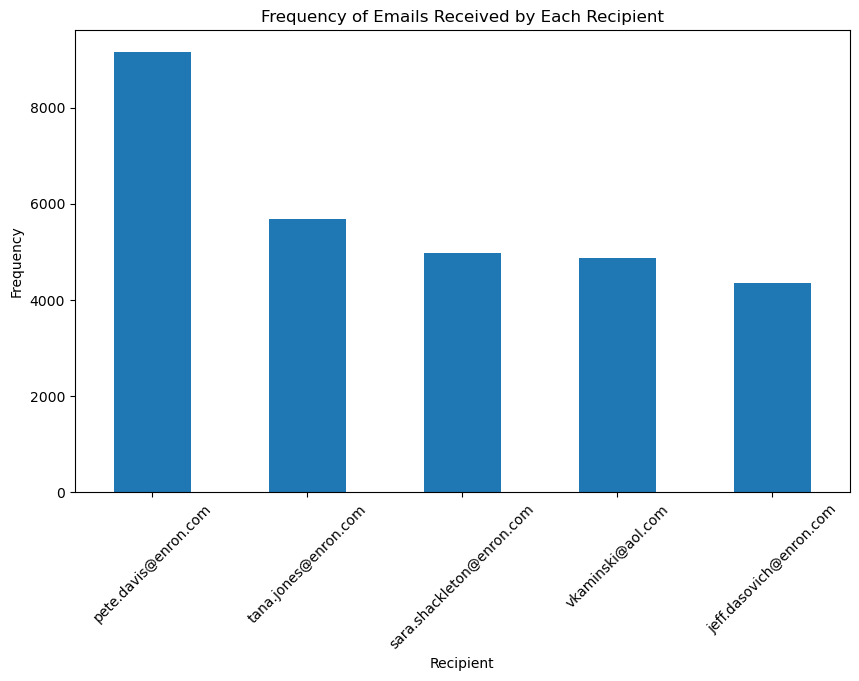

In [22]:
import matplotlib.pyplot as plt

# Count the frequency of each recipient
recipient_counts = selected_data['To'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
recipient_counts.plot(kind='bar')
plt.xlabel('Recipient')
plt.ylabel('Frequency')
plt.title('Frequency of Emails Received by Each Recipient')
plt.xticks(rotation=45)
plt.show()


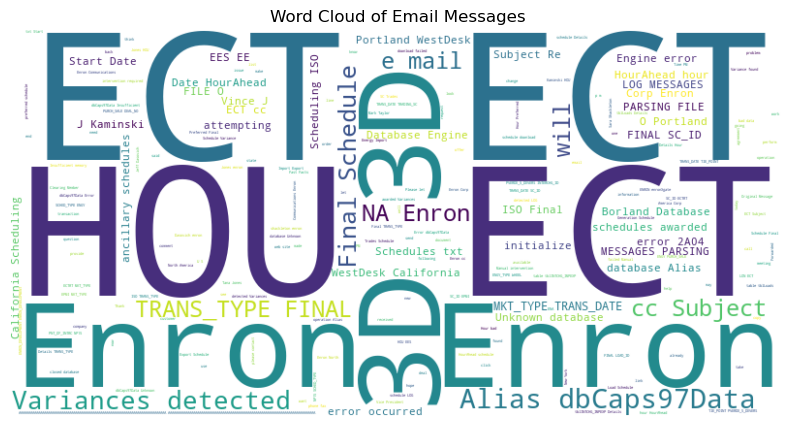

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all the 'body' text into a single string
text = ' '.join(selected_data['body'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Set the title for the plot
plt.title('Word Cloud of Email Messages')

# Show the plot
plt.show()


In [24]:
# Check for null values
null_counts = selected_data.isnull().sum()
print(null_counts)

message    0
Subject    0
From       0
To         0
body       0
user       0
dtype: int64


In [25]:
# Check for duplicate rows
duplicate_rows = selected_data.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


In [26]:
# Preprocessing
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


In [27]:
import nltk

nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
 selected_data.to_csv('selected_data.csv', index=False)


In [29]:
selected_data.to_csv('/kaggle/working/selected_data.csv', index=False)